## Introduction - Skin Care Products : Recommendation System
In this project I have tried to do a highly personalized recommendation of a product for skin care and cosmetics based on 1. user feature similiarities and  2.Chemical composition of ingredients .

The data is scraped from the Sephora website.
This particular notebook explores the data with some relevant insights and visualization to help me relate to the research question and understand the data patterns. 

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import iplot
#from chart_studio.plotly import plot, iplot
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score , roc_auc_score
from collections import defaultdict
from collections import Counter

In [2]:
pd.set_option("max_columns", 30)
skin = pd.read_csv('../data/skindata.csv',index_col=0)
skin.head(3)

Username Skin_Tone    Skin_Type Eye_Color Hair_Color  Rating_Stars  \
0    allyp3    Medium  Combination     Brown   Brunette             5   
1    PatTea    Medium  Combination     Brown        Red             1   
2  Sabi1991   No data      No data   No data    No data             5   

                                              Review  \
0  This is hands down the best cleanser I’ve ever...   
1  Unfortunately this doesn’t work for everyone. ...   
2  My favorite cleanser!! i love the packaging on...   

                          Product                Brand  Price  Rating  \
0  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36     4.4   
1  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36     4.4   
2  Superfood Antioxidant Cleanser  YOUTH TO THE PEOPLE     36     4.4   

                                         Ingredients  Combination  Dry  \
0  Water, Sodium Cocoyl Glutamate, Cocamidopropyl...            0    0   
1  Water, Sodium Cocoyl Glutamate, Cocamidopropyl...            0    0   
2  Water, Sodium Cocoyl Glutamate, Cocamidopropyl...            0    0   

   Normal  Oily  Sensitive  Category  \
0       0     0          0  Cleanser   
1       0     0          0  Cleanser   
2       0     0          0  Cleanser   

                                         Product_Url  User_id  Product_id  \
0  https://www.sephora.com/product/kale-spinach-g...     3420         157   
1  https://www.sephora.com/product/kale-spinach-g...     2483         157   
2  https://www.sephora.com/product/kale-spinach-g...     2715         157   

                                 Ingredients_Cleaned  \
0  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
1  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   
2  ['sodium', 'cocoyl', 'glutamate', 'cocamidopro...   

                                      Review_Cleaned  Good_Stuff  \
0  ['hand', 'best', 'cleanser', 'ever', 'used', '...           1   
1  ['unfortunately', 'work', 'everyone', 'used', ...           0   
2  ['favorite', 'cleanser', 'love', 'packaging', ...           1   

                                           Ing_Tfidf  
0  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
1  sodium, cocoyl, glutamate, cocamidopropyl, bet...  
2  sodium, cocoyl, glutamate, cocamidopropyl, bet...

In [3]:
skin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8649 entries, 0 to 8702
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Username             8649 non-null   object 
 1   Skin_Tone            8649 non-null   object 
 2   Skin_Type            8649 non-null   object 
 3   Eye_Color            8649 non-null   object 
 4   Hair_Color           8649 non-null   object 
 5   Rating_Stars         8649 non-null   int64  
 6   Review               8649 non-null   object 
 7   Product              8649 non-null   object 
 8   Brand                8649 non-null   object 
 9   Price                8649 non-null   int64  
 10  Rating               8649 non-null   float64
 11  Ingredients          8649 non-null   object 
 12  Combination          8649 non-null   int64  
 13  Dry                  8649 non-null   int64  
 14  Normal               8649 non-null   int64  
 15  Oily                 8649 non-null   i

#### Exploring Data

In [4]:
skin.sample(n=5, random_state=1)

Username Skin_Tone    Skin_Type Eye_Color Hair_Color  Rating_Stars  \
3682       nturfe   No data      No data   No data    No data             1   
4707   Roaringbay    Medium       Normal     Brown      Black             5   
5634  dancerchicx    Medium  Combination     Brown   Brunette             5   
1564     Sactown1   No data      No data   No data    No data             5   
82     darint2013   No data      No data   No data    No data             5   

                                                 Review  \
3682  I don’t normally write reviews. But this produ...   
4707  Best face wash I have used. Got rid of blackhe...   
5634  This is my second bottle of this toner, and it...   
1564  I have been use this for 2 weeks now in the mo...   
82    Such good wipes to remove makeup. Pomegranate ...   

                                                Product               Brand  \
3682                                Clarifying Cleanser               MURAD   
4707  Blackhead Solutions 7 Day Deep Pore Cleanse & ...            CLINIQUE   
5634                             Problem Solution Toner               BELIF   
1564           Cold Plasma Sub-D Firming Neck Treatment        PERRICONE MD   
82                        Cleansing & Exfoliating Wipes  SEPHORA COLLECTION   

      Price  Rating                                        Ingredients  \
3682     30     4.3  Water, Cocamidopropyl Betaine, Sodium C14-16 O...   
4707     24     4.2  Water, Kaolin, Glycerin, Butylene Glycol, Magn...   
5634     28     4.3  Water, Dipropylene Glycol, Butylene Glycol, 1,...   
1564    135     3.8  Water, Glycolic Acid, L-Tyrosine, Dimethyl MEA...   
82        7     4.5  Water, Caprylic/Capric Triglyceride, Fragrance...   

      Combination  Dry  Normal  Oily  Sensitive     Category  \
3682            1    1       1     1          1     Cleanser   
4707            1    1       1     1          1     Cleanser   
5634            0    0       0     1          1     Cleanser   
1564            1    1       1     1          1  Moisturizer   
82              0    0       0     0          0     Cleanser   

                                            Product_Url  User_id  Product_id  \
3682  https://www.sephora.com/product/clarifying-cle...     5869          58   
4707  https://www.sephora.com/product/blackhead-solu...     2647          42   
5634  https://www.sephora.com/product/problem-soluti...     4060         204   
1564  https://www.sephora.com/product/cold-plasma-su...     2720          76   
82    https://www.sephora.com/product/cleansing-exfo...     4075          65   

                                    Ingredients_Cleaned  \
3682  ['cocamidopropyl', 'betaine', 'sodium', 'c', '...   
4707  ['kaolin', 'glycerin', 'butylene', 'glycol', '...   
5634  ['dipropylene', 'glycol', 'butylene', 'glycol'...   
1564  ['glycolic', 'acid', 'l', 'tyrosine', 'dimethy...   
82    ['caprylic', 'capric', 'triglyceride', 'fragra...   

                                         Review_Cleaned  Good_Stuff  \
3682  ['normally', 'write', 'horrible', 'bad', 'acne...           0   
4707  ['best', 'face', 'wash', 'used', 'got', 'rid',...           1   
5634  ['second', 'bottle', 'toner', 'favorite', 'adu...           1   
1564  ['use', 'week', 'morning', 'night', 'front', '...           1   
82    ['good', 'wipe', 'remove', 'makeup', 'pomegran...           1   

                                              Ing_Tfidf  
3682  cocamidopropyl, betaine, sodium, c, olefin, su...  
4707  kaolin, glycerin, butylene, glycol, magnesium,...  
5634  dipropylene, glycol, butylene, glycol, hexaned...  
1564  glycolic, acid, l, tyrosine, dimethyl, mea, dm...  
82    caprylic, capric, triglyceride, fragrance, phe...

It has to be noted that there are duplicate product IDs and brands ,meaning many users have tried using same products but of different brands or same products of same brand and have given their ratings and reviews.
Lets see how many unique products are there in this dataset.

In [5]:
skin.isnull().sum()

Username               0
Skin_Tone              0
Skin_Type              0
Eye_Color              0
Hair_Color             0
Rating_Stars           0
Review                 0
Product                0
Brand                  0
Price                  0
Rating                 0
Ingredients            0
Combination            0
Dry                    0
Normal                 0
Oily                   0
Sensitive              0
Category               0
Product_Url            0
User_id                0
Product_id             0
Ingredients_Cleaned    0
Review_Cleaned         0
Good_Stuff             0
Ing_Tfidf              0
dtype: int64

In [6]:
print(skin['Product'].nunique())
print(skin['Brand'].nunique())

315
60


In [7]:
#dropping duplicate occurance by 'name' and 'brand' of product
#skin.drop_duplicates(['Product', 'Brand'], keep="first", inplace = True)

In [8]:
skin.size

216225

In [9]:
skin['Product_id'].value_counts()

32     72
299    48
113    48
58     48
313    48
       ..
49     22
160    22
61     21
269    19
112    19
Name: Product_id, Length: 315, dtype: int64

In [10]:
skin.loc[skin['Product_id'] == 32]

Username Skin_Tone    Skin_Type Eye_Color Hair_Color  Rating_Stars  \
432        JazminLR      Deep          Dry     Brown      Black             5   
433          E12355   No data      No data   No data    No data             2   
434         lenstar       Tan       Normal     Brown      Black             2   
435  ramblinfirefox     Olive          Dry     Brown   Brunette             4   
436         KateraS     Olive       Normal     Hazel   Brunette             5   
..              ...       ...          ...       ...        ...           ...   
499        moni5555    Medium  Combination     Brown   Brunette             4   
500           CMiki   No data      No data   No data    No data             1   
501        dancouns     Light  Combination     Green   Brunette             5   
502  momneedscoffee   No data      No data   No data    No data             5   
503          dhunay   No data      No data   No data    No data             5   

                                                Review        Product  \
432  I love it, is a must have product! I use for m...  Beauty Elixir   
433  My skin feels great, but I can't bare the stro...  Beauty Elixir   
434  Really wanted to like this product but I was r...  Beauty Elixir   
435  I use this as a setting spray, love the scent....  Beauty Elixir   
436  Fresh, Fresh. I'm a bit of a collector of face...  Beauty Elixir   
..                                                 ...            ...   
499  I love this for moisturizing throughout the da...  Beauty Elixir   
500  Stay away sensitive skin!!! This is horrible. ...  Beauty Elixir   
501  Nice as a mid-day pick me up. I leave it on my...  Beauty Elixir   
502  After being introduced to a soothing mist that...  Beauty Elixir   
503  this is such an amazing place product. i am an...  Beauty Elixir   

        Brand  Price  Rating  \
432  CAUDALIE     18     4.3   
433  CAUDALIE     18     4.3   
434  CAUDALIE     18     4.3   
435  CAUDALIE     18     4.3   
436  CAUDALIE     18     4.3   
..        ...    ...     ...   
499  CAUDALIE     18     4.3   
500  CAUDALIE     18     4.3   
501  CAUDALIE     18     4.3   
502  CAUDALIE     18     4.3   
503  CAUDALIE     18     4.3   

                                           Ingredients  Combination  Dry  \
432  Water, Alcohol*, Citrus Aurantium Amara (Bitte...            1    0   
433  Water, Alcohol*, Citrus Aurantium Amara (Bitte...            1    0   
434  Water, Alcohol*, Citrus Aurantium Amara (Bitte...            1    0   
435  Water, Alcohol*, Citrus Aurantium Amara (Bitte...            1    0   
436  Water, Alcohol*, Citrus Aurantium Amara (Bitte...            1    0   
..                                                 ...          ...  ...   
499  Water, Alcohol*, Citrus Aurantium Amara (Bitte...            1    0   
500  Water, Alcohol*, Citrus Aurantium Amara (Bitte...            1    0   
501  Water, Alcohol*, Citrus Aurantium Amara (Bitte...            1    0   
502  Water, Alcohol*, Citrus Aurantium Amara (Bitte...            1    0   
503  Water, Alcohol*, Citrus Aurantium Amara (Bitte...            1    0   

     Normal  Oily  Sensitive     Category  \
432       1     1          1  Moisturizer   
433       1     1          1  Moisturizer   
434       1     1          1  Moisturizer   
435       1     1          1  Moisturizer   
436       1     1          1  Moisturizer   
..      ...   ...        ...          ...   
499       1     1          1  Moisturizer   
500       1     1          1  Moisturizer   
501       1     1          1  Moisturizer   
502       1     1          1  Moisturizer   
503       1     1          1  Moisturizer   

                                           Product_Url  User_id  Product_id  \
432  https://www.sephora.com/product/beauty-elixir-...     1309          32   
433  https://www.sephora.com/product/beauty-elixir-...      866          32   
434  https://www.sephora.com/product/beauty-elixir-...     5189          32   
435  h

#### Visualizing the Data

In [11]:
#How many product categories do we have and how many products in each of those categories ? 
print(skin['Category'].unique())
print(skin['Rating'].unique())
print(skin['Category'].value_counts())
print(skin['Skin_Type'].unique())

['Cleanser' 'Moisturizer' 'Face Mask' 'Treatment']
[4.4 4.5 4.1 4.2 4.6 4.7 4.3 4.9 3.8 3.9 4.  4.8 3.5 3.3 3.6 5.  0.  3.7]
Cleanser       4117
Moisturizer    2560
Treatment      1948
Face Mask        24
Name: Category, dtype: int64
['Combination' 'No data' 'Dry' 'Normal' 'Oily']


In [12]:
skin['Skin_Type'] = skin['Skin_Type'].str.replace('No data', "Any")
skin['Skin_Tone'] = skin['Skin_Tone'].str.replace('No data', "Any")
skin['Eye_Color'] = skin['Eye_Color'].str.replace('No data', "Any")
skin['Hair_Color'] = skin['Hair_Color'].str.replace('No data', "All")

In [13]:
#Average rating for each product.
skin.groupby('Product')['Rating'].max()

Product
+Retinol Vita C Power Serum                             3.9
100 percent Pure Argan Oil                              4.5
100 percent Pure Argan Oil Light                        4.4
3 Muslin Cloths                                         4.3
3% Glycolic Solutions Cleanser                          4.4
                                                       ... 
Waterproof Eye Makeup Remover                           4.4
White Lucent Brightening Cleansing Foam                 4.5
Witch Hazel Herbal Extract Toner                        4.6
Wrinkle Warrior™ 2-in-1 Plumping Moisturizer + Serum    3.9
Zero Oil™ Pore Purifying Toner                          4.3
Name: Rating, Length: 315, dtype: float64

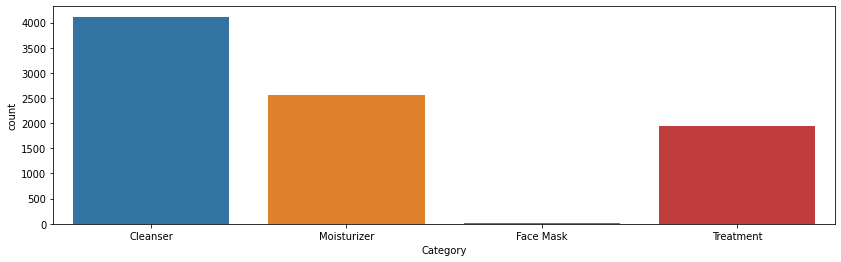

<Figure size 432x288 with 0 Axes>

In [14]:
#Distribution of products in each category
fig = plt.figure(figsize = (14,4))
sns.countplot(data=skin,x='Category')
plt.show()
sns.despine()

As seen above, Sephora offers a huge collection of facial cleansers for its customers, but least options for face masks.

Text(0.5, 1.0, 'Price ranges by Category')

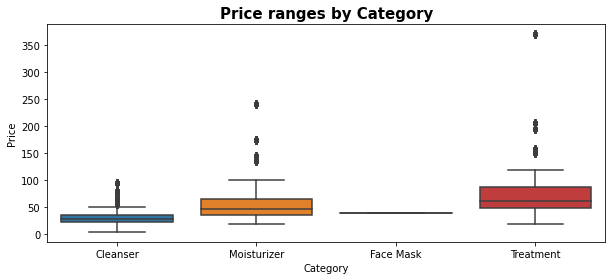

In [15]:
fig = plt.figure(figsize = (10,4))
sns.boxplot( x="Category", y="Price", data=skin)
#plt.xticks(rotation = 90);

plt.title('Price ranges by Category', weight = 'bold', fontsize = 15)


And as expected, treatment products have the highest average price among all the available skin care products.

Inorder to recommend a system based on user feature similiarity, the user can input their skin-tone , skin type, eye color and hair color to get a list of matching products in return.
So let's analyze these features.
To start with, the first thing I noticed is there are a lot of "No data" in the values for skin type, tone, Eye color and hair color.

In [16]:
'''''skin_typenodata = skin[skin['Skin_Type'] == 'No data']
missing_percent1 = len(skin_typenodata)/len(skin) * 100
print("We have", len(skin_typenodata), "records with no values for skin type entered",'These records reflect',round(missing_percent1,2), "% of the data")

skin_tonenodata = skin[skin['Skin_Tone'] == 'No data']
missing_percent2 = len(skin_tonenodata)/len(skin) * 100
print("We have", len(skin_tonenodata), "records with no values for skin tone entered",'These records reflect',round(missing_percent2,2), "% of the data")

eye_colornodata = skin[skin['Eye_Color'] == 'No data']
missing_percent3 = len(eye_colornodata)/len(skin) * 100
print("We have", len(eye_colornodata), "records with no values for eye color entered",'These records reflect',round(missing_percent3,2), "% of the data")

hair_colornodata = skin[skin['Hair_Color'] == 'No data']
missing_percent4 = len(hair_colornodata)/len(skin) * 100
print("We have", len(hair_colornodata), "records with no values for hair color entered",'These records reflect',round(missing_percent4,2), "% of the data")
       
skin_nodata = skin.loc[(skin['Skin_Type'] == 'No data') & (skin['Skin_Tone'] == 'No data') & (skin['Eye_Color'] == 'No data') & (skin['Hair_Color'] == 'No data')]    
missing_percent = len(skin_nodata)/len(skin) * 100
print("We have", len(skin_nodata), "records with no values for any of the features",'These records reflect',round(missing_percent,2), "% of the data")'''''


'\'\'skin_typenodata = skin[skin[\'Skin_Type\'] == \'No data\']\nmissing_percent1 = len(skin_typenodata)/len(skin) * 100\nprint("We have", len(skin_typenodata), "records with no values for skin type entered",\'These records reflect\',round(missing_percent1,2), "% of the data")\n\nskin_tonenodata = skin[skin[\'Skin_Tone\'] == \'No data\']\nmissing_percent2 = len(skin_tonenodata)/len(skin) * 100\nprint("We have", len(skin_tonenodata), "records with no values for skin tone entered",\'These records reflect\',round(missing_percent2,2), "% of the data")\n\neye_colornodata = skin[skin[\'Eye_Color\'] == \'No data\']\nmissing_percent3 = len(eye_colornodata)/len(skin) * 100\nprint("We have", len(eye_colornodata), "records with no values for eye color entered",\'These records reflect\',round(missing_percent3,2), "% of the data")\n\nhair_colornodata = skin[skin[\'Hair_Color\'] == \'No data\']\nmissing_percent4 = len(hair_colornodata)/len(skin) * 100\nprint("We have", len(hair_colornodata), "record

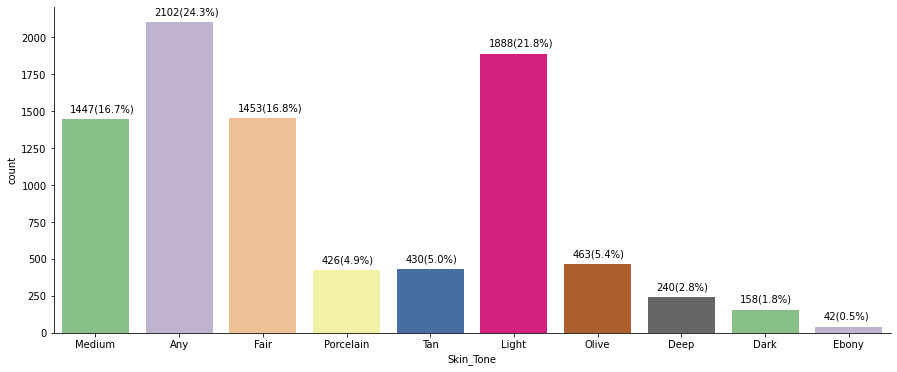

In [17]:
skintone_stats = skin[["Skin_Tone","Username"]]
fig = plt.figure(figsize=[15,6])
ax = sns.countplot(data=skintone_stats,x='Skin_Tone',palette='Accent')
for p in ax.patches:
        ax.annotate(str(p.get_height())+'('+str((p.get_height()/len(skintone_stats)*100).round(1))+'%)',(p.get_x()+0.1, p.get_height()+50))
sns.despine()

Around 24% of the products have no particular info regarding the skin tone.

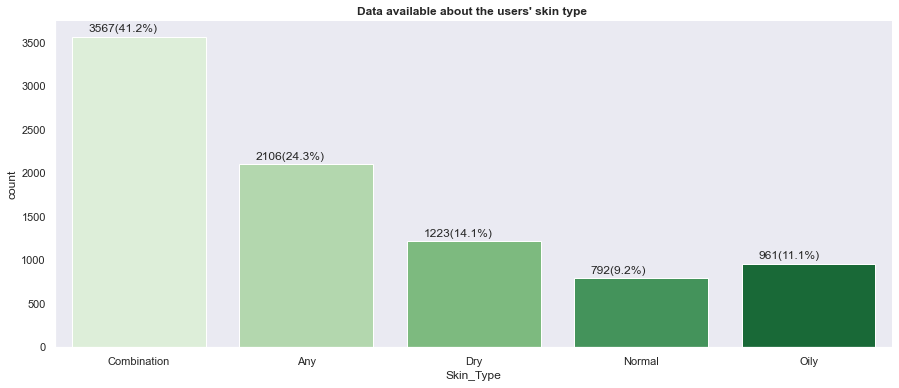

In [18]:
sns.set(style='dark')
skintype_stats = skin[['Skin_Type','Username']]
fig = plt.figure(figsize=[15,6])
ax = sns.countplot(data=skintype_stats,x='Skin_Type',palette='Greens')
plt.title("Data available about the users' skin type ",weight="bold")
for p in ax.patches:
        ax.annotate(str(p.get_height())+'('+str((p.get_height()/len(skintype_stats)*100).round(1))+'%)',(p.get_x()+0.1, p.get_height()+50))
sns.despine()

Again , 24% of the products are not specific to the choices of skin-type or probably , meaning they could be used for all skin types.

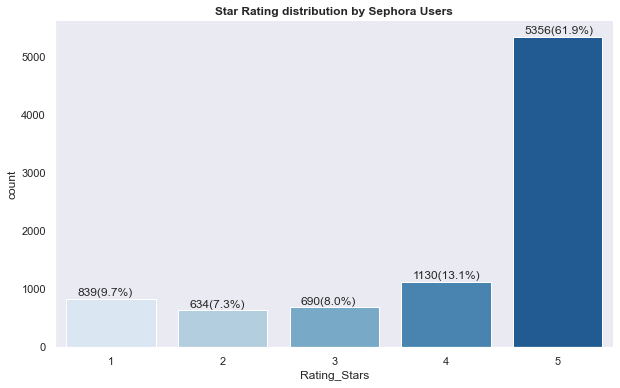

In [19]:
rating_stats = skin[['Rating_Stars','Username']]
fig = plt.figure(figsize=[10,6])
ax = sns.countplot(data=rating_stats,x='Rating_Stars',palette='Blues')
plt.title("Star Rating distribution by Sephora Users", weight = 'bold')
for p in ax.patches:
        ax.annotate(str(p.get_height())+'('+str((p.get_height()/len(rating_stats)*100).round(1))+'%)',(p.get_x()+0.1, p.get_height()+50))
sns.despine()

The rating distribution looks quite uneven than expected.I was hoping to see a somewhat balanced distribution or atleast most of the products having 3 star or 4 star as people don't get so easily satisfied with all the aspects of a product.
This might cause an imbalance in the classification models.

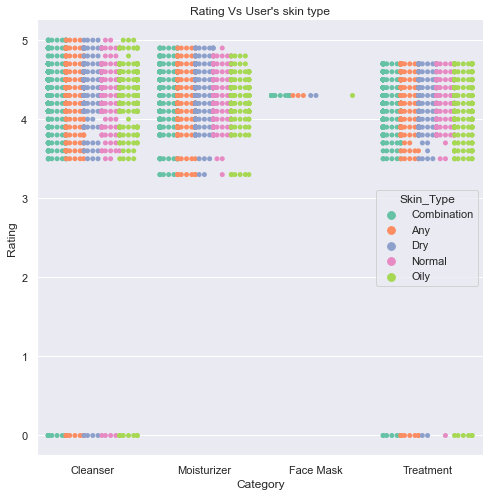

In [20]:
fig = plt.figure(figsize=[8,8])
sns.set(style='darkgrid')
sns.swarmplot(x="Category", y="Rating",hue = 'Skin_Type',edgecolor='gray',dodge=True,
data=skin,palette="Set2")
sns.despine()
plt.title("Rating Vs User's skin type")
plt.show() 

Most products offered in Sephora have an overwhelmingly high rating. 
There are just a few low ratings for Cleansers and Treatments.

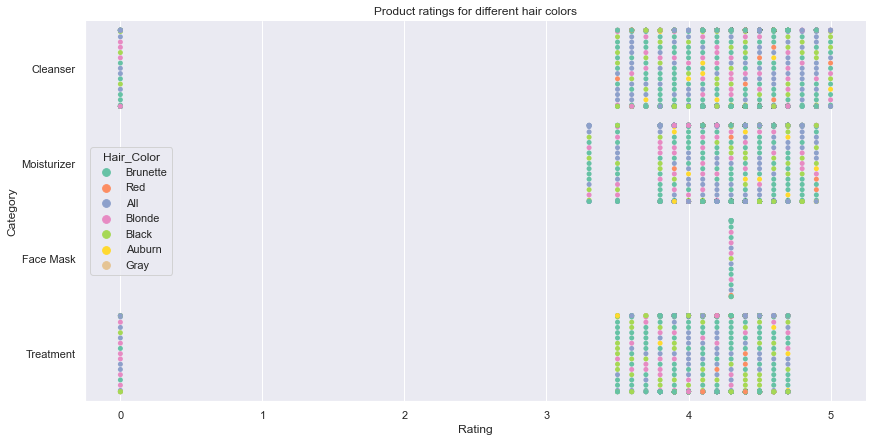

In [21]:
fig = plt.figure(figsize=[14,7])
sns.set(style='darkgrid')
sns.swarmplot(y="Category", x="Rating",hue = 'Hair_Color',data=skin,palette="Set2")
sns.despine()
plt.title("Product ratings for different hair colors")
plt.show()

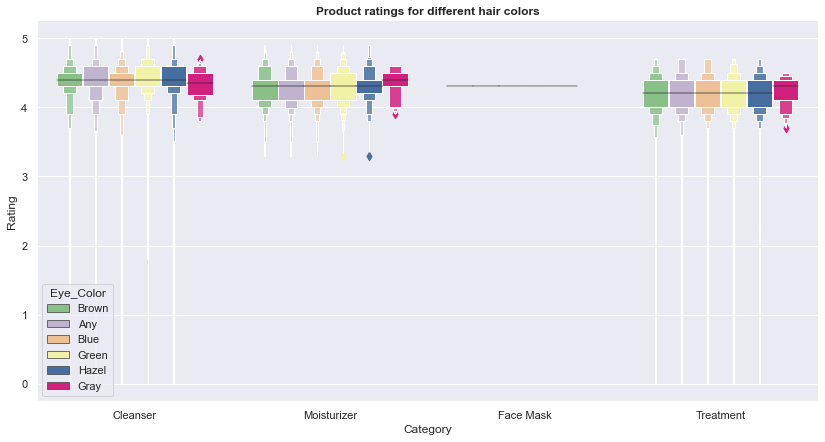

In [22]:
fig = plt.figure(figsize=[14,7])
sns.set(style='darkgrid')
sns.boxenplot(x="Category", y="Rating",hue = 'Eye_Color',data=skin,palette="Accent")
sns.despine()
plt.title("Product ratings for different hair colors" , weight="bold")
plt.show()

#### Sensitive skin care 

In [23]:
skin['Sensitive'].value_counts()

1    4457
0    4192
Name: Sensitive, dtype: int64

<AxesSubplot:xlabel='Category'>

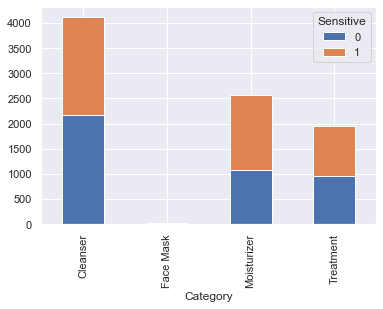

In [24]:
# Product distribution for sensitive skin care per category
df_plot = skin.groupby(['Sensitive', 'Category']).size().reset_index().pivot(columns='Sensitive', index='Category', values=0)
df_plot.plot(kind='bar', stacked=True)

The distribution of products for the sensitive skin care groups is quite balanced against its counterpart.
It can be seen that there are slightly more moisturizers for sensitive skin.

In [25]:
# Product distribution for Normal skin per category
#df_comb = skin.loc[(skin['Combination'] == 1) & (skin['Dry']==1) & (skin['Normal']== 1) & (skin['Oily']==1) & (skin['Sensitive']==1)]
#plt.hist()

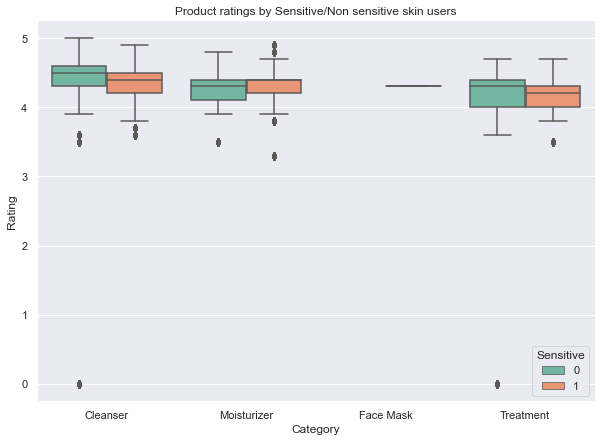

In [26]:
fig = plt.figure(figsize=[10,7])
sns.set(style='darkgrid')
sns.boxplot(x="Category", y="Rating",hue = 'Sensitive',data=skin,palette="Set2")
sns.despine()
plt.title("Product ratings by Sensitive/Non sensitive skin users")
plt.show() 

There's no siginificant difference in the rating of products based on the sensitivity.

#### Price of Products
Visualizing relation between the price and its rating  - Are customers happy with the brand and quality of the product even if its expensive ?

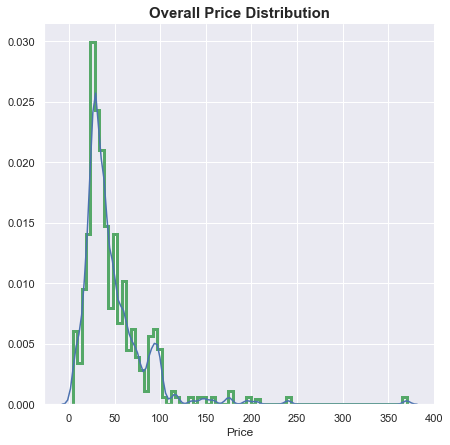

In [27]:
#Let's first take a look at how pricey the products in Sephora are .
plt.figure(figsize = (7,7))
df_price = skin['Price']
sns.set(style='darkgrid')
sns.distplot(df_price,bins=75,hist=True,hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"})
plt.title("Overall Price Distribution", weight = "bold",fontsize = 15)
sns.despine()

Well, Sephora offers a lot of products within 100EUR.

<Figure size 720x504 with 0 Axes>

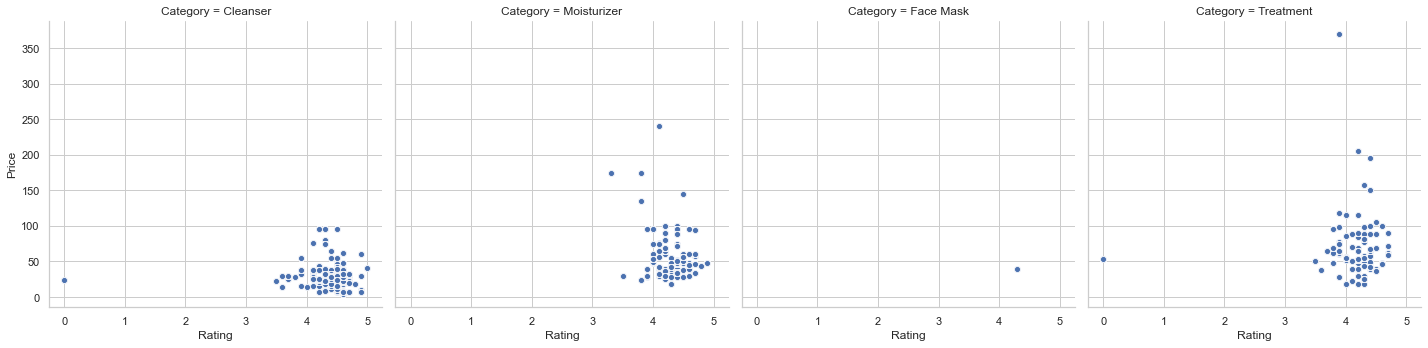

In [28]:
plt.figure(figsize = (10,7))
sns.set(style="whitegrid")
ax = sns.relplot(x='Rating',y='Price',data=skin,col='Category',kind='scatter',ci=95)
sns.despine()

The price of the product always has an influence on the category it falls under.
Just like, how here the Treatment products in skin care are a bit costlier than the cheapest Cleansers and the moisturizers.
It can be otherwise said as one cannot find a good collection of Treatment products in the lower price range unlike Cleansers.  
However,from the Ratings given by customers ,it seems that they're satisfied with the quality of products in Sephora despite the high prices.

What does the feature "Good stuff" say?

c:\users\gurur\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.



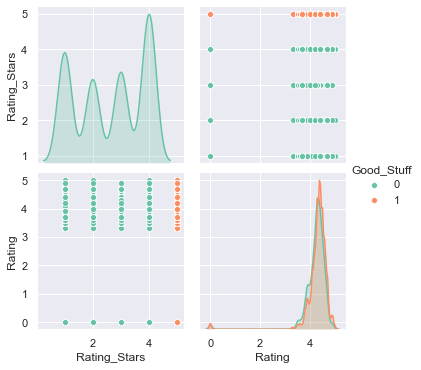

In [29]:
sns.set(style='darkgrid')
g = sns.pairplot(skin, vars=['Rating_Stars','Rating'], hue="Good_Stuff",diag_kind='kde',palette="Set2")
sns.despine()

Ingredient Analysis

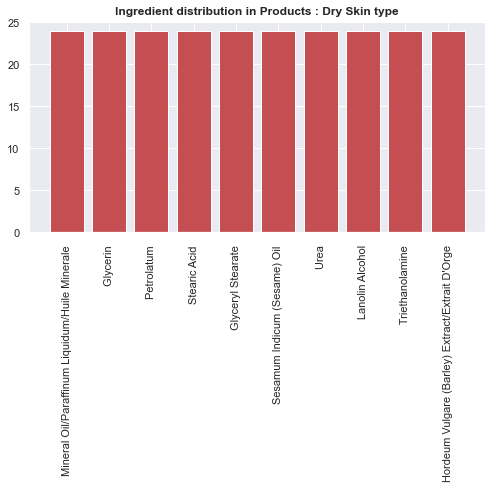

In [30]:
#Overall ingredients by skin type, strict
val_dry = Counter(" ".join(skin[(skin['Combination'] == 1) & (skin['Dry']==1) & (skin['Normal']==0) & (skin['Oily']==0) & (skin['Sensitive']==0)]['Ingredients']).split(',')).most_common(10)

word, frequency = zip(*val_dry)
indices = np.arange(len(val_dry))

plt.figure(figsize = (7,7))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation= 90)
plt.title("Ingredient distribution in Products : Dry Skin type" , weight = "bold")
plt.tight_layout()
plt.show()

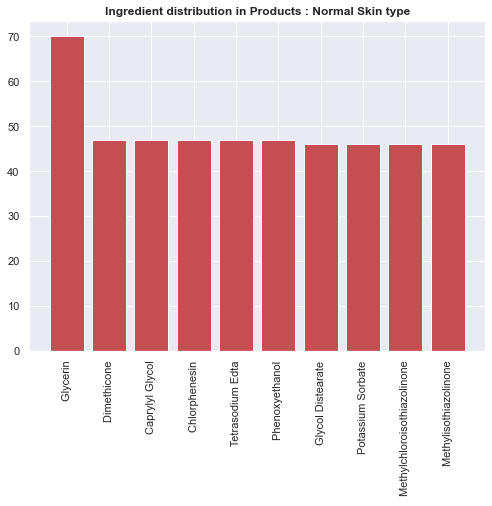

In [31]:
#Ingredients in the product for a normal skin type
val_norm = Counter(" ".join(skin[(skin['Dry']==0) & (skin['Normal']==1) & (skin['Oily']==0) & (skin['Sensitive']==0)]['Ingredients']).split(',')).most_common(10)
word, frequency = zip(*val_norm)
indices = np.arange(len(val_norm))

plt.figure(figsize = (7,7))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.title("Ingredient distribution in Products : Normal Skin type" , weight = "bold")
plt.show()

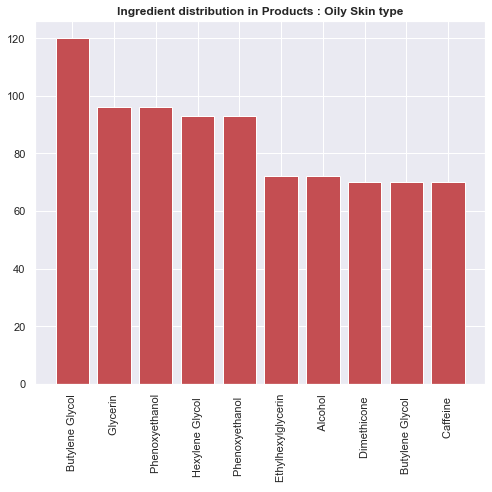

In [32]:
val_oily = Counter(" ".join(skin[(skin['Dry']==0) & (skin['Normal']==0) & (skin['Oily']==1) & (skin['Sensitive']==0)]['Ingredients']).split(',')).most_common(10)

word, frequency = zip(*val_oily)
indices = np.arange(len(val_oily))

plt.figure(figsize = (7,7))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.title("Ingredient distribution in Products : Oily Skin type" , weight = "bold")
plt.tight_layout()
plt.show()

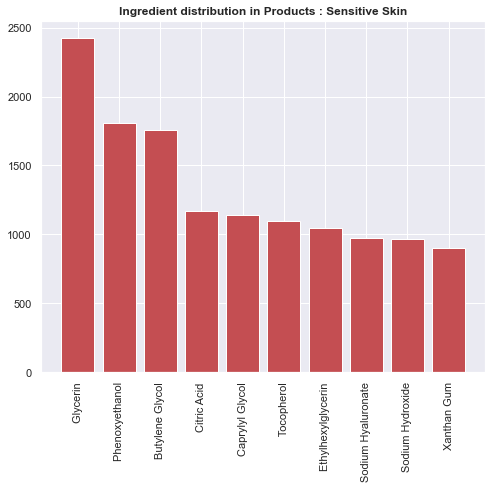

In [33]:
val_senstv = Counter(" ".join(skin[(skin['Sensitive']==1)]['Ingredients']).split(',')).most_common(10)

word, frequency = zip(*val_senstv)
indices = np.arange(len(val_senstv))

plt.figure(figsize = (7,7))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.title("Ingredient distribution in Products : Sensitive Skin" , weight = "bold")
plt.tight_layout()
plt.show()

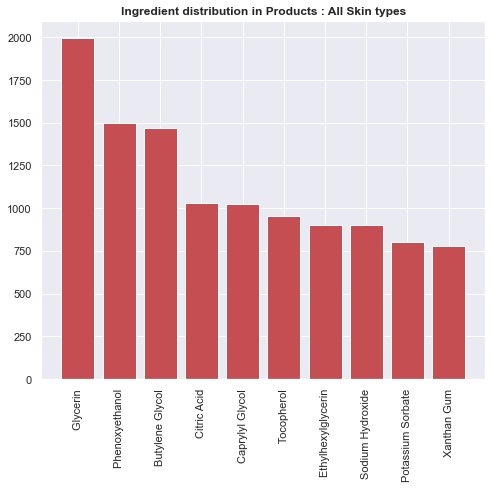

In [34]:
val_all = Counter(" ".join(skin[(skin['Dry']==1) & (skin['Normal']==1) & (skin['Oily']==1) & (skin['Sensitive']==1)]['Ingredients']).split(',')).most_common(10)

word, frequency = zip(*val_all)
indices = np.arange(len(val_all))

plt.figure(figsize = (7,7))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.title("Ingredient distribution in Products : All Skin types" , weight = "bold")
plt.tight_layout()
plt.show()

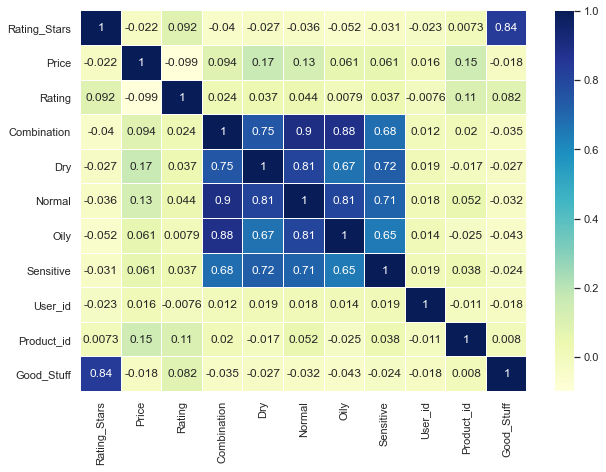

In [35]:
# correlation matrix between columns with heatmap
plt.figure(figsize=(10,7))
sns.heatmap(skin.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

Rating stars and Good_Stuff are highly positively correlated, which is obvious that the more the number of stars for a product, more likely the customer marks it as a good stuff/recommend the product. 

People with dry skin tend to have more sensitive skin too.

In [36]:
## NLP - WordCloud and Classification

In [37]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [38]:
# Since most of the rating stars lie in between 4 and 5 ,Rating stars more than 4 are considered to be positive reviews , while those less than or equal to 4 are taken as negative.
negative_df = skin[skin.Rating_Stars <= 4]
positive_df = skin[skin.Rating_Stars > 4]
negative = " ".join(review for review in negative_df.Review)
positive = " ".join(review for review in positive_df.Review)

In [39]:
stopwords = set(STOPWORDS)
stopwords.update(['read', 'more', 'product'])

In [40]:
def generate_wordcloud(data):
    wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(data)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

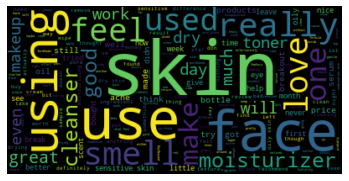

In [41]:
generate_wordcloud(negative)

The most commonly found remarks in the negative reviews are about the smell of the product, texture was kind of oily than expected etc.

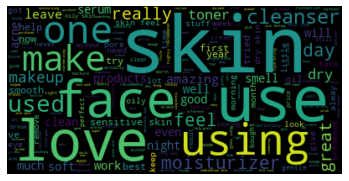

In [42]:
generate_wordcloud(positive)

### Problem Statement : Is it possible to distinguish between the products using its ingredients ?

In [43]:
X = skin.Ingredients
y = skin.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [44]:
categories = ['Moisturizer', 'Cleanser', 'Face Mask', 'Treatment']

In [45]:
#Naive Bayes
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.9653259361997226
              precision    recall  f1-score   support

 Moisturizer       0.96      0.99      0.98      1031
    Cleanser       0.00      0.00      0.00         9
   Face Mask       0.99      0.96      0.98       649
   Treatment       0.94      0.92      0.93       474

    accuracy                           0.97      2163
   macro avg       0.72      0.72      0.72      2163
weighted avg       0.96      0.97      0.96      2163



c:\users\gurur\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [46]:
#Logistic Regression
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.9833564493758669
              precision    recall  f1-score   support

 Moisturizer       0.99      0.97      0.98      1031
    Cleanser       1.00      1.00      1.00         9
   Face Mask       0.97      1.00      0.98       649
   Treatment       0.98      0.99      0.98       474

    accuracy                           0.98      2163
   macro avg       0.99      0.99      0.99      2163
weighted avg       0.98      0.98      0.98      2163



c:\users\gurur\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [47]:
#SVG with SGD
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.9754969949144706
              precision    recall  f1-score   support

 Moisturizer       0.99      0.97      0.98      1031
    Cleanser       1.00      1.00      1.00         9
   Face Mask       0.96      1.00      0.98       649
   Treatment       0.97      0.96      0.96       474

    accuracy                           0.98      2163
   macro avg       0.98      0.98      0.98      2163
weighted avg       0.98      0.98      0.98      2163



#### Using both Logistic Regression and SVG models, I can classify products into the different categories using the ingredients contained in it.
#### Logistic Regression gave a higher accuracy of 98.3% compared to SVD which is 97.5% accurate.

#### Entering only a part of search characters of the product name or search in lower case should return the relevant product details.
#### Thus the code below does just that.

In [48]:
user_input = 'acne treatment'
#making sure user input is going to be interpreted properly
title = skin[skin['Product'].str.lower().str.contains(user_input.lower())]
title.reset_index(inplace = True)
title= title.drop(columns = ['index'])
title

Username Skin_Tone    Skin_Type Eye_Color Hair_Color  Rating_Stars  \
0     DGiffin6714     Light          Dry     Brown      Black             4   
1         dimanta     Light  Combination     Hazel     Blonde             5   
2        Jackay11       Any          Any       Any        All             5   
3       bekbekbek     Light  Combination     Hazel     Auburn             5   
4    kelseyterese       Tan  Combination     Brown      Black             5   
..            ...       ...          ...       ...        ...           ...   
115       hodgesg       Any          Any       Any        All             4   
116    MeghanBNYC    Medium  Combination     Brown      Black             1   
117     goldmine3       Tan  Combination     Brown      Black             1   
118    levans0322     Light         Oily     Hazel   Brunette             3   
119   snowflakes1      Deep  Combination     Brown      Black             5   

                                                Review  \
0    I have been struggling with adult acne for the...   
1    I was sceptical of this cleanser because I tri...   
2    This cleanser is absolutely amazing. Give this...   
3    This product single-handedly got my acne under...   
4    I love this cleanser. I use it twice a day and...   
..                                                 ...   
115  This works great as a treatment mask for 20-30...   
116  Absolutely does not work. I’m pretty sure the ...   
117  Didn't help with acne. You can find same ingre...   
118  Before getting into anything else, this mask w...   
119  Perfect for pesky breakout as an over night tr...   

                                      Product            Brand  Price  Rating  \
0    EradiKate® Daily Cleanser Acne Treatment  KATE SOMERVILLE     38     4.3   
1    EradiKate® Daily Cleanser Acne Treatment  KATE SOMERVILLE     38     4.3   
2    EradiKate® Daily Cleanser Acne Treatment  KATE SOMERVILLE     38     4.3   
3    EradiKate® Daily Cleanser Acne Treatment  KATE SOMERVILLE     38     4.3   
4    EradiKate® Daily Cleanser Acne Treatment  KATE SOMERVILLE     38     4.3   
..                                        ...              ...    ...     ...   
115         Saturn Sulfur Acne Treatment Mask     SUNDAY RILEY     55     4.3   
116         Saturn Sulfur Acne Treatment Mask     SUNDAY RILEY     55     4.3   
117         Saturn Sulfur Acne Treatment Mask     SUNDAY RILEY     55     4.3   
118         Saturn Sulfur Acne Treatment Mask     SUNDAY RILEY     55     4.3   
119         Saturn Sulfur Acne Treatment Mask     SUNDAY RILEY     55     4.3   

                                           Ingredients  Combination  Dry  \
0    Water, Sodium Cocoyl Isethionate, Coco-Glucosi...            1    0   
1    Water, Sodium Cocoyl Isethionate, Coco-Glucosi...            1    0   
2    Water, Sodium Cocoyl Isethionate, Coco-Glucosi...            1    0   
3    Water, Sodium Cocoyl Isethionate, Coco-Glucosi...            1    0   
4    Water, Sodium Cocoyl Isethionate, Coco-Glucosi...            1    0   
..                                                 ...          ...  ...   
115  Water, Sulfur, Isoamyl Laurate, Cetyl Ethylhex...            1    1   
116  Water, Sulfur, Isoamyl Laurate, Cetyl Ethylhex...            1    1   
117  Water, Sulfur, Isoamyl Laurate, Cetyl Ethylhex...            1    1   
118  Water, Sulfur, Isoamyl Laurate, Cetyl Ethylhex...            1    1   
119  Water, Sulfur, Isoamyl Laurate, Cetyl Ethylhex...            1    1   

     Normal  Oily  Sensitive   Category  \
0         1     1          0   Cleanser   
1         1     1          0   Cleanser   
2         1     1          0   Cleanser   
3         1     1          0   Cleanser   
4         1     1          0   Cleanser   
..      ...   ...        ...        ...   
115       1     1          1  Treatment   
116       1     1          1  Treatment   
117       1     1          1  Treatment   
118       1     1          1  Treatment   
119 

### Defining a function to use plotly 3.X versions¶

In [49]:
def configure_plotly_browser_state():
    import IPython
    #import plotly.graph_objs as go 
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

Ratings distribution by Item

In [50]:
configure_plotly_browser_state()
import plotly.graph_objs as go
data = skin.groupby('Product_id')['Rating'].count().clip(upper=50)
# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Item (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Item'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Ratings distribution by User

In [51]:

configure_plotly_browser_state()

data = skin.groupby('User_id')['Rating'].count().clip(upper=80)
# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

## Problem statement 1 : Can we predict if a product will get 5-star rating based on its ingredients?

### Using Model-based Collaborative filtering

What is the factor hidden behind the 5-star rating given by a user for a product? 
For any product, quality is the key for satisfaction and for skin care products its'no different at all! The quality will be decided by the ingredients used to prepare it.

Now I try to predict if a product will get 5-star rating or not using its'ingredients?

In [52]:
X1 = skin['Ingredients']
y1 = skin['Good_Stuff']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25, random_state = 42)

In [53]:
# Whether 5-star or not ends up in a binary classification problem
cat = ['1', '0']

#### Naive Bayes

In [54]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train1, y_train1)

y_pred1 = nb.predict(X_test1)

print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1, target_names=cat))

accuracy 0.5973185390661119
              precision    recall  f1-score   support

           1       0.48      0.25      0.33       856
           0       0.63      0.82      0.71      1307

    accuracy                           0.60      2163
   macro avg       0.56      0.54      0.52      2163
weighted avg       0.57      0.60      0.56      2163



#### Logistic Regression

In [55]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train1, y_train1)


y_pred1 = logreg.predict(X_test1)

print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1, target_names=cat))

accuracy 0.603791030975497
              precision    recall  f1-score   support

           1       0.50      0.25      0.33       856
           0       0.63      0.84      0.72      1307

    accuracy                           0.60      2163
   macro avg       0.56      0.54      0.53      2163
weighted avg       0.58      0.60      0.57      2163



c:\users\gurur\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



accuracy 0.6116504854368932
              precision    recall  f1-score   support

           1       0.61      0.05      0.09       856
           0       0.61      0.98      0.75      1307

    accuracy                           0.61      2163
   macro avg       0.61      0.51      0.42      2163
weighted avg       0.61      0.61      0.49      2163



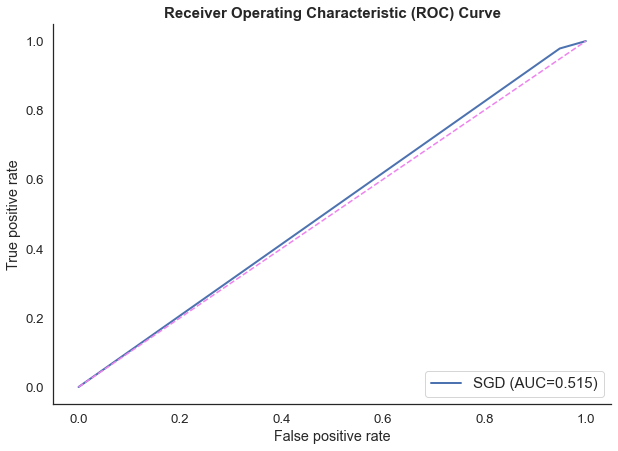

In [56]:
#SVG with SGD
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train1, y_train1)

y_pred1 = sgd.predict(X_test1)

print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1,target_names=cat))

fpr, tpr, thresholds = metrics.roc_curve(y_test1, y_pred1)

sns.set(style='white',font_scale=1.2)
fig = plt.figure(figsize=[10,7])
plt.plot(fpr, tpr,lw=2,label='SGD (AUC={:.3f})'.format(roc_auc_score(y_test1,y_pred1)))
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc="lower right",fontsize=15)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic (ROC) Curve',weight='bold',fontsize=15);
sns.despine()
plt.savefig('ROCplot.png',transparent=True, bbox_inches='tight')

#### Unfortunately, the maximum accuracy achieved is only 60% from among all the models trained as above. So, the answer is No, we can't really predict the star rating as there might be an influence on the price of the product as well.

### Surprise - Model Selection

Using Python Scikit's Surprise library also has a lot of awesome predicting estimators. 

Here are the average RMSE, MAE and total execution time of various algorithms (with their default parameters) on a 3-fold cross-validation procedure.

We will be comparing SVD, Normal Predictor, KNN Basic and will be using the one which will have least RMSE value.

Some understanding on the algorithms before we start applying.

1: Normal Predictor: It predicts a random rating based on the distribution of the training set, which is assumed to be normal. It's a basic algorithm that does not do much work but that is still useful for comparing accuracies.

2: SVD: It got popularized by Simon Funk during the Netflix prize and is a Matrix Factorized algorithm. If baselines are not used, it is equivalent to PMF.It employs the use of gradient descent to minimize the squared error between predicted rating and actual rating, eventually getting the best model.

3: KNN Basic: This is a basic collaborative filtering algorithm method.

In [57]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate 
from surprise.model_selection import train_test_split as tts
from surprise.model_selection import RandomizedSearchCV
from surprise.model_selection import GridSearchCV

In [58]:
#Load the dataset from a pandas dataframe with "load_from_df" and define the reader object to be able to parse the file/dataframe.
#data = skin[['User_id', 'Product_id', 'Rating']]
#reader = Reader(line_format='user item rating', sep=',')
#data = Dataset.load_from_df(data, reader=reader)

#trainset, testset = tts(data, test_size=.2)

In [59]:
#svd = SVD()
#svd.fit(trainset)

In [60]:
#predictions = svd.test(testset)
#accuracy.rmse(predictions)
#accuracy.mae(predictions)

In [61]:
from surprise import NormalPredictor
from surprise import KNNBasic

data = skin[['User_id', 'Product_id', 'Rating']]
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_df(data, reader=reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NormalPredictor(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [62]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

test_rmse  fit_time  test_time
Algorithm                                      
SVD               0.137562  0.344548   0.015293
KNNBasic          0.368946  0.511779   0.047242
NormalPredictor   0.645007  0.007296   0.019971

### Tuning algorithm parameters with to find the best parameters for the algorithm.

The lowest RMSE obtained is for SVD , hence we proceed with the tuning of hyperparameters with this model.
Default values for svd( ):

n_factors - 100,                                                                                                                n_epochs - 20,
lr_all – 0.005,
reg_all – 0.02

In [63]:
param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

#Assigning values
t = gs.best_params
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']

0.1029596238113909
{'n_factors': 25, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.08}


#### Training and Testing
We use the train_test_split() to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse.

We’ll then use the fit() method which will train the algorithm on the trainset, and the test() method which will return the predictions made from the testset

In [64]:
trainset, testset = tts(data, test_size=0.25, random_state = 10)
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.0974


0.0974157715186863

Let's check how good or bad our predictions are:¶
The following function will create a pandas data frame which will consist of these columns:

UID: user-id

iid: item id

Rui: the rating given by the user

est: rating estimated by the model

Iu: No of items rated by the user

UI: number of users that have rated this item

err: abs difference between predicted rating and the actual rating.

In [65]:
def get_Iu(uid):
    """ 
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ 
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

    
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)

In [66]:
df_predictions.head()

uid  iid  rui       est                    details  Iu  Ui       err
0  3456  142  4.3  4.308608  {'was_impossible': False}   0  16  0.008608
1  5253   17  0.0  1.000000  {'was_impossible': False}   0  15  1.000000
2  4664  151  4.0  4.051097  {'was_impossible': False}   0  17  0.051097
3  1887  159  4.4  4.384449  {'was_impossible': False}   0  18  0.015551
4   287  311  4.5  4.468398  {'was_impossible': False}   0  18  0.031602

####  Let's see the 10 best and worst predictions our model made

In [67]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [68]:
best_predictions

uid  iid  rui       est                    details  Iu  Ui       err
213   4581  246  4.4  4.400012  {'was_impossible': False}   1  37  0.000012
1859  1908  296  4.3  4.300021  {'was_impossible': False}   2  16  0.000021
1730  1532   42  4.2  4.199936  {'was_impossible': False}   1  34  0.000064
1591  3035  145  4.3  4.299896  {'was_impossible': False}   1  39  0.000104
1752  2292  270  4.4  4.399696  {'was_impossible': False}   1  17  0.000304
623    975  218  4.3  4.299647  {'was_impossible': False}  21  17  0.000353
814   4497  157  4.4  4.400472  {'was_impossible': False}   2  37  0.000472
364   2661  118  4.3  4.300493  {'was_impossible': False}   1  20  0.000493
1726  4512  249  4.4  4.399500  {'was_impossible': False}   1  37  0.000500
1773  1446   21  4.3  4.299490  {'was_impossible': False}   1  18  0.000510

In [69]:
worst_predictions

uid  iid  rui  est                    details  Iu  Ui  err
1704  2170   62  0.0  1.0  {'was_impossible': False}   1  39  1.0
23    1766   62  0.0  1.0  {'was_impossible': False}   1  39  1.0
1917  2037   17  0.0  1.0  {'was_impossible': False}   0  15  1.0
72    6490   62  0.0  1.0  {'was_impossible': False}   0  39  1.0
488   6739   62  0.0  1.0  {'was_impossible': False}   1  39  1.0
2106  4687   17  0.0  1.0  {'was_impossible': False}   1  15  1.0
1638  2382   17  0.0  1.0  {'was_impossible': False}   0  15  1.0
929   5836   17  0.0  1.0  {'was_impossible': False}   0  15  1.0
1807  3331   17  0.0  1.0  {'was_impossible': False}   0  15  1.0
218   6490   62  0.0  1.0  {'was_impossible': False}   0  39  1.0

In [70]:
skin.loc[skin['Product_id'] == 62]['Rating'].describe()

count    46.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: Rating, dtype: float64

##  K Recommendations
### Recall and precision at K
Recall and precision are the classical evaluation metric and are used to evaluate the binary metric and so we have to convert our rating which is scaled from (1-5) into a binary problem relevant and not relevant items.

#### Conversion to binary
To do the translation we have to select an arbitrary value on which we can say any rating above that will be considered relevant. There are many methods on selecting that value but for now, we will select 4 as the threshold, which means any true rating above 4 will be considered relevant and below will be not relevant.

#### Deciding 'k'
In recommendation systems, we are interested in showing the top N items to users and so the best is to compute precision and recall on top N values instead of calculating on all the items.

#### Definition of Relevant and Recommended
Relevant: True Rating > = 4

Irrelevant: True Rating < 4

Recommended item: Predicted Rating > = 4

Not Recommended item: Predicted Rating > = 4

#### Definition of Precision and Recall
Precision: It tries to answer "What proportion of positive identifications was actually correct?" i.e True positive / (True positive+False Positive) in RecSys we can say (# of recommended items @k that are relevant) / (# of recommended items @k)

Recall: It tries to answer "What proportion of actual positives were identified correctly?" i.e True positive / (True Positive+False Negative) in RecSys we can say (# of recommended items @k that are relevant) / (# of relevant items @k)

While recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant.

In some circumstances, we might know that we need to maximize either recall or precision at the cost of the other metric. For example, in disease screening of patients, we would probably want a recall near 1.0 i.e. we want to find all patients who have the disease.

However, in cases where we want to obtain an optimal blend of precision and recall, we can use F1 score which is the harmonic mean of precision and recall taking both metrics into account while calculating it.

f1 score = 2 (precision recall) / (precision + recall)

The below function computes precision and recall and F1 socre as explained above.

In [71]:
#Calculate TP,FP,TN,FN at every threshold level (0.0 - 5.0)

final = []

for threshold in np.arange(0, 5.5, 0.5):
  tp=0
  fn=0
  fp=0
  tn=0
  temp = []

  for uid, _, true_r, est, _ in predictions:
    if(true_r>=threshold):
      if(est>=threshold):
        tp = tp+1
      else:
        fn = fn+1
    else:
      if(est>=threshold):
        fp = fp+1
      else:
        tn = tn+1   

    if tp == 0:
      precision = 0
      recall = 0
      f1 = 0
    else:
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * (precision * recall) / (precision + recall)  

  temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
  final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

threshold    tp  fp    tn   fn  Precision    Recall        F1
0         0.0  2163   0     0    0   1.000000  1.000000  1.000000
1         0.5  2147  16     0    0   0.992603  1.000000  0.996288
2         1.0  2147  16     0    0   0.992603  1.000000  0.996288
3         1.5  2147   0    16    0   1.000000  1.000000  1.000000
4         2.0  2147   0    16    0   1.000000  1.000000  1.000000
5         2.5  2147   0    16    0   1.000000  1.000000  1.000000
6         3.0  2147   0    16    0   1.000000  1.000000  1.000000
7         3.5  2142   0    21    0   1.000000  1.000000  1.000000
8         4.0  1939   2   219    3   0.998970  0.998455  0.998712
9         4.5   426   0  1458  279   1.000000  0.604255  0.753316
10        5.0     0   0  2151   12   0.000000  0.000000  0.000000

As per the results above, the optimal value for threshold is 4.0.

The next step is to find the optimal K value, and to find it we have to first calculate precision and recall for all the K values(2-10) having threshold value 4.0.

Below is the function to calculate precision and recall @ K.

In [72]:

def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    #tp = n_rel_and_rec_k
    #fn =  n_rel - tp
    #fp = n_rec_k - tp
    return precisions, recalls

In [73]:
results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold= 4.0)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    

results

[{'K': 2, 'Precision': 0.9990029910269193, 'Recall': 0.9965437022266533},
 {'K': 3, 'Precision': 0.9990029910269193, 'Recall': 0.9981804586241275},
 {'K': 4, 'Precision': 0.9990029910269193, 'Recall': 0.998654037886341},
 {'K': 5, 'Precision': 0.9990029910269193, 'Recall': 0.998753738783649},
 {'K': 6, 'Precision': 0.9990029910269193, 'Recall': 0.998753738783649},
 {'K': 7, 'Precision': 0.9990029910269193, 'Recall': 0.998753738783649},
 {'K': 8, 'Precision': 0.9990029910269193, 'Recall': 0.998753738783649},
 {'K': 9, 'Precision': 0.9990029910269193, 'Recall': 0.998753738783649},
 {'K': 10, 'Precision': 0.9990029910269193, 'Recall': 0.998753738783649}]

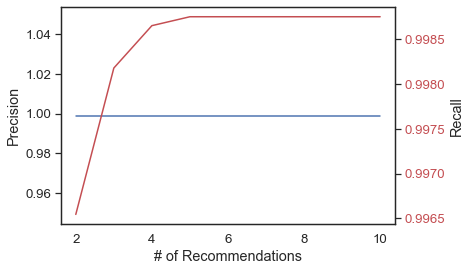

In [74]:
Rec=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

from matplotlib import pyplot as plt
plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')

## Time to recommend some products to users
Now as we know the optimal number of recommendations to provie, it's time to give recommendations to users. 
To do so we have to predict ratings for the products which user has not yet tried before.

Here we will be using build_anti_testset() method to get the data for testset as we have to predict ratings for the (user, product) pairs which are not present.

In [75]:
#data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()   #Build on entire data set
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

Function below to get the predictions sorted 

In [76]:

def get_all_predictions(predictions):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n

all_pred = get_all_predictions(predictions)

In [77]:
#To get top  reommendation
n = 5

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]

As we have all the predicted rating, We'll subset to only top K products for every user, where K is 4

In [78]:
tmp = pd.DataFrame(all_pred)
tmp_transpose = tmp.transpose()

Now we have a dataframe which contains the top 5 products recommended to every user.
Let's try one example and find recommendations for user# 17

In [79]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results

In [80]:
user_id = 67
results = get_predictions(user_id)
results

0     (97, 4.921270781347454)
1     (178, 4.85108086819869)
2    (109, 4.841161995966314)
3    (117, 4.827089565432623)
4    (108, 4.819083143251098)
Name: 67, dtype: object

The above matrix is showing top "4" recommendations for user 67. (Product-id, Predicted-Rating).
But we just need the products not the ratings, so let's extract the product id's from the result.

In [81]:
recommended_prod_ids=[]
for x in range(0, n):
    recommended_prod_ids.append(results[x][0])

recommended_prod_ids

[97, 178, 109, 117, 108]

Now as we have the product-id's to be recommended, Let's find out the product details of those id's by reading the product data

In [82]:
recommended_products = skin[skin['Product_id'].isin(recommended_prod_ids)]
reco = len(recommended_products.loc[recommended_products['Good_Stuff'] == 1])
print("Out of " +str(len(recommended_products))+  " users who tried this product, " +str(reco)+  " would recommend this product")

Out of 144 users who tried this product, 112 would recommend this product


In [83]:
recommended_products.rename(columns = {'Ing_Tfidf':'Ingredients_cleaned'}, inplace = True)
recommended_df = recommended_products.loc[:,['Product', 'Product_id', 'Category','Ingredients_cleaned', 'Product_Url', 'Rating']]
recommended_df

c:\users\gurur\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Product  Product_id  Category  \
600                       Facial Cotton         117  Cleanser   
601                       Facial Cotton         117  Cleanser   
602                       Facial Cotton         117  Cleanser   
603                       Facial Cotton         117  Cleanser   
604                       Facial Cotton         117  Cleanser   
...                                 ...         ...       ...   
6019  Multi-Miracle Glow Cleansing Balm         178  Cleanser   
6020  Multi-Miracle Glow Cleansing Balm         178  Cleanser   
6021  Multi-Miracle Glow Cleansing Balm         178  Cleanser   
6022  Multi-Miracle Glow Cleansing Balm         178  Cleanser   
6023  Multi-Miracle Glow Cleansing Balm         178  Cleanser   

                                    Ingredients_cleaned  \
600                                                info   
601                                                info   
602                                                info   
603                                                info   
604                                                info   
...                                                 ...   
6019  glycerin, caprylic, capric, triglyceride, cycl...   
6020  glycerin, caprylic, capric, triglyceride, cycl...   
6021  glycerin, caprylic, capric, triglyceride, cycl...   
6022  glycerin, caprylic, capric, triglyceride, cycl...   
6023  glycerin, caprylic, capric, triglyceride, cycl...   

                                            Product_Url  Rating  
600   https://www.sephora.com/product/facial-cotton-...     4.9  
601   https://www.sephora.com/product/facial-cotton-...     4.9  
602   https://www.sephora.com/product/facial-cotton-...     4.9  
603   https://www.sephora.com/product/facial-cotton-...     4.9  
604   https://www.sephora.com/product/facial-cotton-...     4.9  
...                                                 ...     ...  
6019  https://www.sephora.com/product/multi-miracle-...     4.9  
6020  https://www.sephora.com/product/multi-miracle-...     4.9  
6021  https://www.sephora.com/product/multi-miracle-...     4.9  
6022  https://www.sephora.com/product/multi-miracle-...     4.9  
6023  https://www.sephora.com/product/multi-miracle-...     4.9  

[144 rows x 6 columns]

In [84]:
recommended_df.drop_duplicates(inplace=True)
recommended_df

Product  Product_id     Category  \
600                                 Facial Cotton         117     Cleanser   
1776            Evercalm™ Overnight Recovery Balm         108  Moisturizer   
4776  Epidermal Re-Texturizing Micro-Dermabrasion          97     Cleanser   
5256            Exfoilating Wipes - Papaya - Glow         109     Cleanser   
6000            Multi-Miracle Glow Cleansing Balm         178     Cleanser   

                                    Ingredients_cleaned  \
600                                                info   
1776  coco, caprylate, caprate, glycerin, almond, bo...   
4776  alumina, paraffinum, liquidum, mineral, oil, g...   
5256                                               info   
6000  glycerin, caprylic, capric, triglyceride, cycl...   

                                            Product_Url  Rating  
600   https://www.sephora.com/product/facial-cotton-...     4.9  
1776  https://www.sephora.com/product/evercalm-overn...     4.9  
4776  https://www.sephora.com/product/epidermal-re-t...     5.0  
5256  https://www.sephora.com/product/exfoilating-wi...     4.9  
6000  https://www.sephora.com/product/multi-miracle-...     4.9

# Problem statement : Can we predict price of a product based on its ingredients?

1. It is possible to distinguish between the product categories from its ingredients.
2. Price has an influence on the category i.e treatment products are more expensive than cleansers and moisturizers.

Combining the above 2 facts, I've tried predicting price of products based on its ingredients.

#### Raw modeling to predict 5-star rating of a product from its ingredients

In [85]:
X = skin['Ingredients'] #setting our X variable

y = skin['Price'] #our y variable is price_per_ounce

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,  test_size=.33, stratify = y)

In [86]:
#CountVactorizer splits the ingredients by comma and not in to individual words
cvec = CountVectorizer(tokenizer=lambda x: x.split(', '))
#training CountVectorizer and transforming
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

Train     Test Train R^2  Test R^2
Linear Regression  5.29487  5.65032  0.978047  0.975155
KNN                5.54501  5.86903  0.975923  0.973194
Decision Tree      5.29487  5.65032  0.978047  0.975155
Bagging            5.29768  5.63162  0.978023  0.975319
Random Forest      5.30866  5.60154  0.977932  0.975582
AdaBoost           27.1297  27.0739   0.42366  0.429571
SVR                28.2769  28.1988  0.373889  0.381182

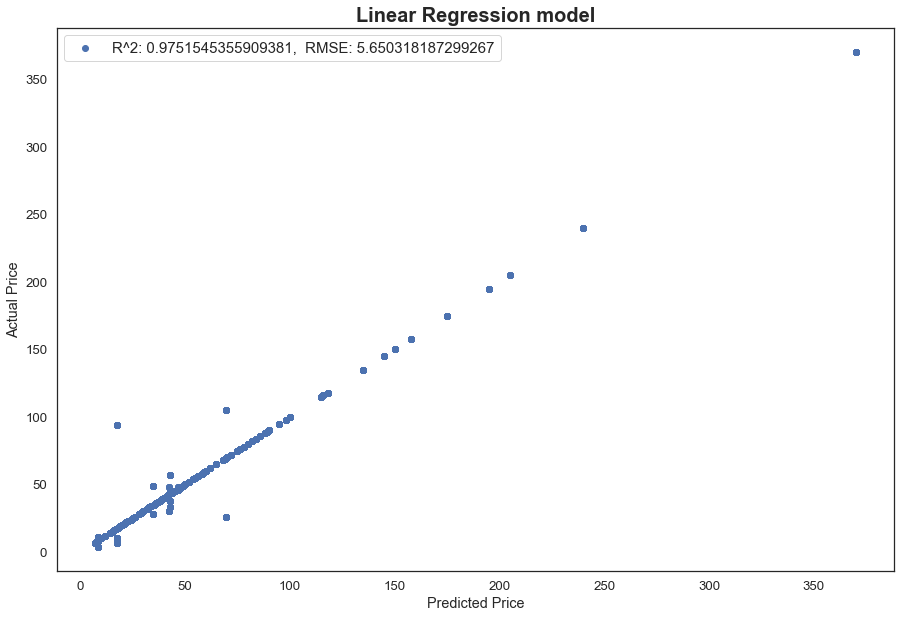

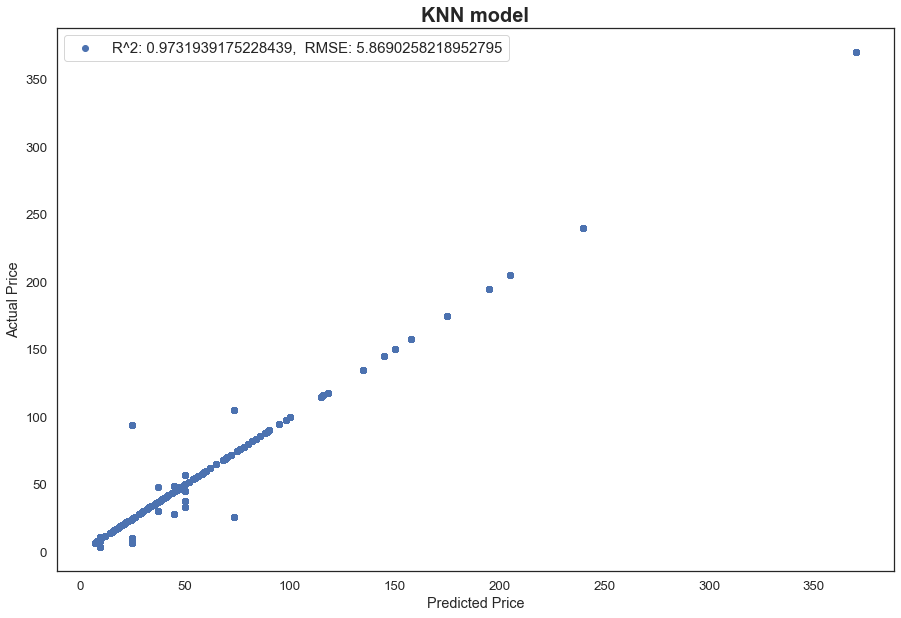

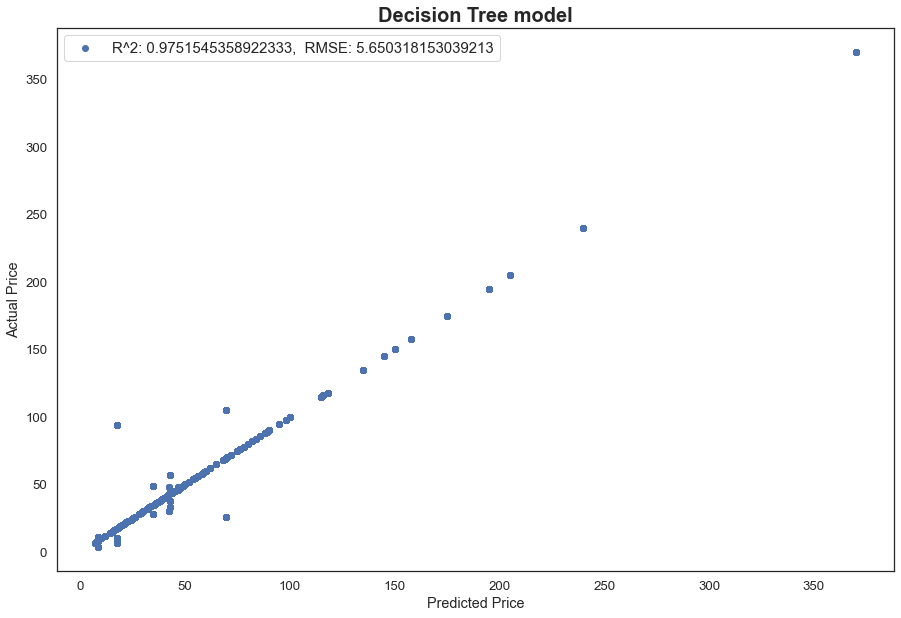

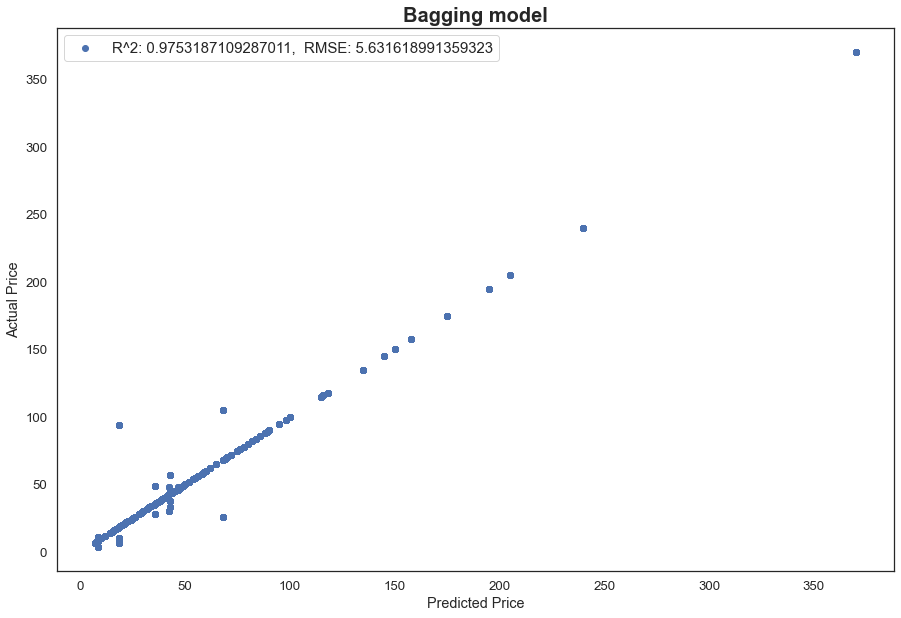

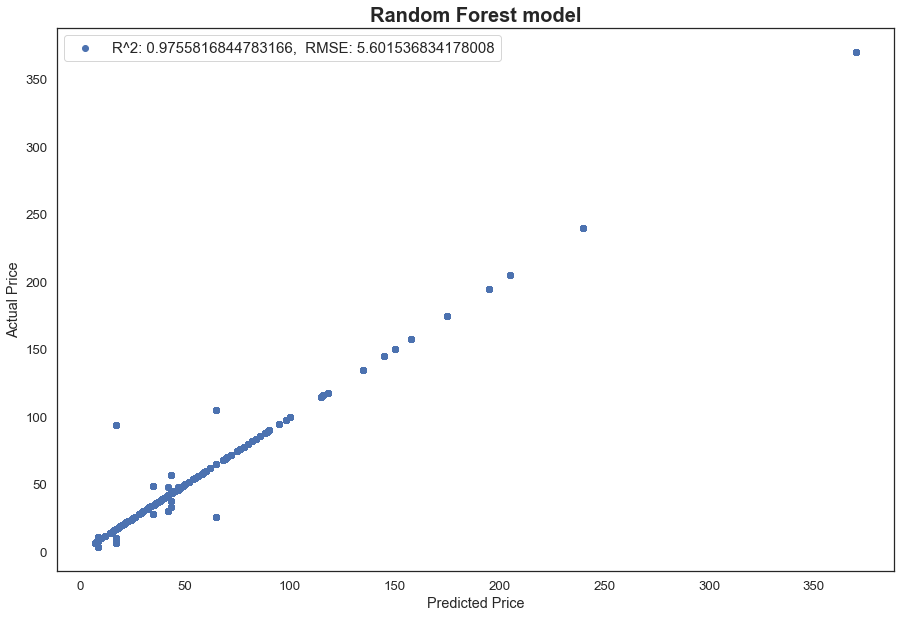

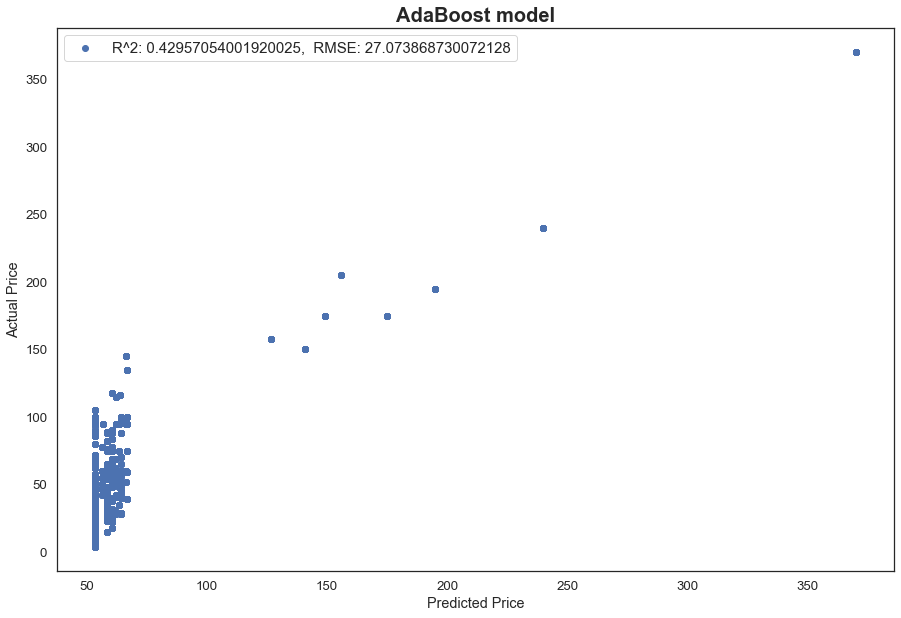

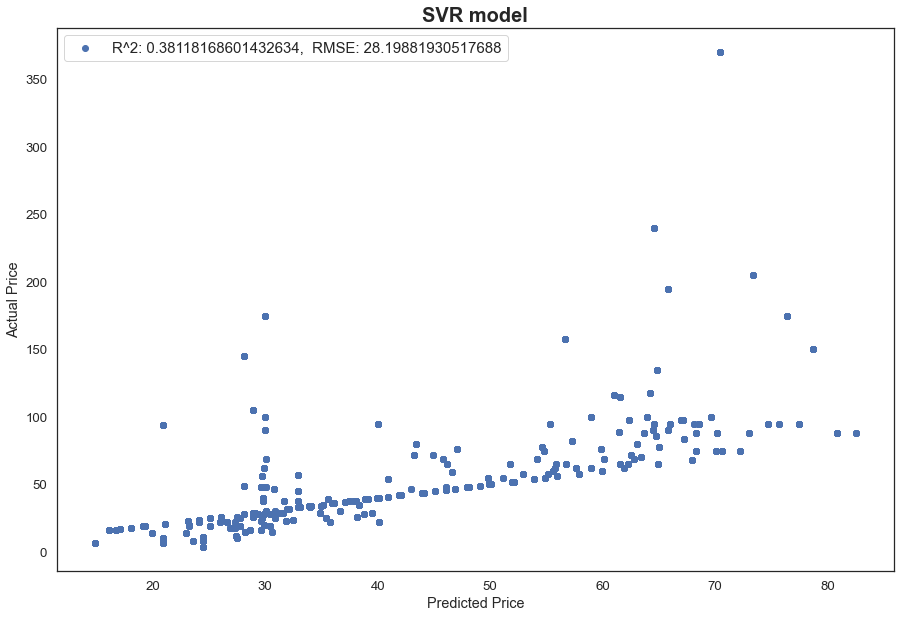

In [87]:
#instantiating the models
lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=42)
bdt = BaggingRegressor(random_state=42)
rf = RandomForestRegressor(n_estimators = 10)
abr = AdaBoostRegressor(random_state = 42)
svr = SVR(gamma = 'scale')

models = {
    'Linear Regression': lr,
    'KNN': knn, 
    'Decision Tree': dt, 
    'Bagging': bdt, 
    'Random Forest': rf, 
    'AdaBoost': abr,
    'SVR': svr
}
#list of model names
model_names = ['Linear Regression', 'KNN', 'Decision Tree', 'Bagging', 'Random Forest', 'AdaBoost', 'SVR']
#creating a data frame that rmse scores will go in to
rmse_all_cvec = pd.DataFrame(index = model_names, columns = ['Train', 'Test', 'Train R^2', 'Test R^2'])
#fitting the models and calculating their rmse
for x in models:
    models[x].fit(X_train_cvec, y_train) #fitting the model
    y_train_preds = models[x].predict(X_train_cvec) #prediction for train
    y_test_preds = models[x].predict(X_test_cvec) #prediction for test
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_preds)) #rmse for train
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_preds)) #rmse for test
    rmse_all_cvec.loc[x, 'Train'] = rmse_train #updating the dataframe
    rmse_all_cvec.loc[x, 'Test'] = rmse_test
    rmse_all_cvec.loc[x, 'Train R^2'] = models[x].score(X_train_cvec, y_train)
    rmse_all_cvec.loc[x, 'Test R^2'] = models[x].score(X_test_cvec, y_test)
    
    plt.figure(figsize = (15,10))
    plt.scatter(y_test_preds, y_test)

    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('{} model'.format(x), weight='bold', fontsize=20);
    plt.legend(['R^2: {},  RMSE: {}'.format(models[x].score(X_test_cvec, y_test), rmse_test)], loc = 'upper left', fontsize = 15);
    
    
    
rmse_all_cvec

AdaBoost and SVR were not good model choices. All the other models have a high R2 score (97%) meaning they explain more than 97% of the variations in the response variable around its mean.

### Collaborative filtering with Lightfm

In [88]:
from scipy import sparse
from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k,recall_at_k

c:\users\gurur\appdata\local\programs\python\python37\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning:

LightFM was compiled without OpenMP support. Only a single thread will be used.



In [89]:
def create_interaction_matrix(skin, user_col, item_col, rating_col, norm= False, threshold = None):
    interactions = skin.groupby([user_col, item_col])[rating_col].sum().unstack().reset_index().fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [90]:
interaction_matrix = create_interaction_matrix(skin=skin, user_col='User_id', item_col = 'Product_id', rating_col='Rating_Stars')
interaction_matrix.head()

Product_id  0    1    2    3    4    5    6    7    8    9    10   11   12   \
User_id                                                                       
0           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Product_id  13   14   ...  300  301  302  303  304  305  306  307  308  309  \
User_id               ...                                                     
0           0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2           0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3           0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4           0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Product_id  310  311  312  313  314  
User_id                              
0           0.0  0.0  0.0  0.0  0.0  
1           0.0  0.0  0.0  0.0  0.0  
2           0.0  0.0  0.0  0.0  0.0  
3           0.0  0.0  0.0  0.0  0.0  
4           0.0  0.0  0.0  0.0  0.0  

[5 rows x 315 columns]

In [91]:
def runMF(interactions, n_components=30, loss='warp', k=10, epoch=30,n_jobs = 4):
    x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components= n_components, loss=loss,k=k)
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    train_auc = auc_score(model, x, num_threads=n_jobs).mean()
    print('Collaborative filtering AUC: %s' % train_auc)
    print("Train precision: %.4f" % precision_at_k(model, x, k=k,num_threads=n_jobs).mean())
    print("Train Recall: %.4f" % recall_at_k(model, x, k=k,num_threads=n_jobs).mean())

    return model

In [92]:
mf_model = runMF(interactions = interaction_matrix,
                 n_components = 30,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

Collaborative filtering AUC: 0.99999976
Train precision: 0.1092
Train Recall: 0.9999


In [93]:
def create_user_dict(interactions):
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [94]:
user_dict = create_user_dict(interaction_matrix)

In [95]:
def create_item_dict(skin, id_col, name_col):
    item_dict ={}
    for i in skin.index:
        item_dict[(skin.loc[i, id_col])] = skin.loc[i, name_col]
    return item_dict

In [96]:
product_dict = create_item_dict(skin = skin, id_col = 'Product_id', name_col = 'Product')

In [97]:
def sample_recommendation_user(model, interactions, user_id, user_dict,
                               item_dict, threshold = 0, nrec_items = 10, show = True):

    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    #print(scores)
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    #print(return_score_list)
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))

    if show == True:
        print(scores)

    return scores

In [98]:
rec_list = sample_recommendation_user(model = mf_model, 
                                      interactions = interaction_matrix, 
                                      user_id = 4792, 
                                      user_dict = user_dict,
                                      item_dict = product_dict, 
                                      threshold = 4,
                                      nrec_items = 10,
                                      show = True)

['Advanced Night Repair Synchronized Recovery Complex II', 'Make-Up Removing Cleansing Oil', 'POWER Advanced Wrinkle Fighter 360° Eye Serum', 'Ultra Facial Cream SPF 30', 'The Clean Truth™ Foaming Cleanser', 'Advanced Acne & Wrinkle Reducer', 'Liquid Facial Soap', 'Ultra Repair® Cream Intense Hydration', 'Seaberry Moisturizing Face Oil', 'Pure Clean Daily Facial Cleanser']


### Python implementation of Recommendation based only on User features

In [99]:
def recommend_products_by_user_features(skintone, skintype, eyecolor, haircolor, percentile=0.85):
    ddf = skin[(skin['Skin_Tone'] == skintone) & (skin['Hair_Color'] == haircolor) & (skin['Skin_Type'] == skintype) & (skin['Eye_Color'] == eyecolor)]
    
    recommendations = ddf[(ddf['Rating_Stars'].notnull())][['Rating_Stars', 'Product', 'Product_Url','Category']]
    recommendations = recommendations.sort_values('Rating_Stars', ascending=False).head(10)
    
    print('Based on your features, these are the top products for you:')
    return recommendations

In [111]:
recommend_products_by_user_features('Light', 'Dry','Brown', 'Black')

Based on your features, these are the top products for you:


Rating_Stars                                            Product  \
557              5  Take The Day Off Makeup Remover For Lids, Lash...   
3766             5                       Sugar Face Polish Exfoliator   
4833             5                     Eudermine Revitalizing Essence   
4862             5                         Rinse-Off Foaming Cleanser   
581              5  Take The Day Off Makeup Remover For Lids, Lash...   
5475             5                                  The Cleansing Gel   
5845             5                              Perfect Cleansing Oil   
6301             5                                Clarifying Lotion 1   
6478             5        GENIUS Ultimate Anti-Aging Melting Cleanser   
6680             5                        +Retinol Vita C Power Serum   

                                            Product_Url     Category  
557   https://www.sephora.com/product/take-the-day-o...     Cleanser  
3766  https://www.sephora.com/product/sugar-face-pol...     Cleanser  
4833  https://www.sephora.com/product/eudermine-revi...  Moisturizer  
4862  https://www.sephora.com/product/rinse-off-foam...     Cleanser  
581   https://www.sephora.com/product/take-the-day-o...     Cleanser  
5475  https://www.sephora.com/product/the-cleansing-...     Cleanser  
5845  https://www.sephora.com/product/perfect-cleans...     Cleanser  
6301  https://www.sephora.com/product/clarifying-lot...     Cleanser  
6478  https://www.sephora.com/product/genius-ultimat...     Cleanser  
6680  https://www.sephora.com/product/retinol-vita-c...    Treatment

### Content-based recommendation based on the ingredients/ chemical composition of products

In [101]:
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [102]:
skin_ing = skin[['Product', 'Product_id', 'Ingredients', 'Product_Url', 'Ing_Tfidf', 'Rating','Category']]
skin_ing.drop_duplicates(inplace=True)

c:\users\gurur\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [103]:
#Creating a TF-IDF Vectorizer for ingredients feature
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(skin_ing['Ingredients'])

In [104]:
#Calculating cosine similiarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [105]:
skin_ing = skin_ing.reset_index(drop=True)
titles = skin_ing[['Product', 'Ingredients', 'Rating','Category']]
indices = pd.Series(skin_ing.index, index=skin_ing['Product'])

In [106]:
#Performing recommendations based on the similiarity in the ingredients.

def content_recommendations(product):
    idx = indices[product]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    product_indices = [i[0] for i in sim_scores]
    return titles.iloc[product_indices]

In [107]:
content_recommendations('Water Drench Hyaluronic Cloud Cream')

Product  \
286              Water Drench Hyaluronic Cloud Serum   
60                        Nutrient-Charged Water Gel   
192                              Prep-N-Glow™ Cloths   
226      GENIUS Ultimate Anti-Aging Vitamin C+ Serum   
287              Hyaluronic Marine Hydration Booster   
31                                  Ceramidin™ Cream   
312  Hydro-Plumping Re-Texturizing Serum Concentrate   
239             POWER Recharging Night Pressed Serum   
291        Bye Bye Breakout™ Full-Coverage Concealer   
283                         Anti Bac Clearing Lotion   

                                           Ingredients  Rating     Category  
286  Water, Saccharide Isomerate, Sodium Hyaluronat...     4.2    Treatment  
60   Water, Dimethicone, Glycerin, Propanediol, Sac...     4.6  Moisturizer  
192  Water, Polyglyceryl-4 Laurate/Succinate, Betai...     4.7     Cleanser  
226  Water, Glycerin, Butylene Glycol, 3-O-Ethyl As...     3.9    Treatment  
287  Oenothera Biennis (Evening Primrose) Flower/Le...     4.4    Treatment  
31   Water, Glycerin, Dipropylene Glycol, Cetearyl ...     4.6  Moisturizer  
312  Water, Glycerin, Dimethicone, Propanediol, Dim...     4.7    Treatment  
239  Cocos Nucifera (Coconut) Water, Water (Aqua, E...     4.4  Moisturizer  
291  Cyclopentasiloxane, Water, Dimethicone/Vinyl D...     3.9    Treatment  
283  Water, PPG-2 Myristyl Ether Propionate, Argani...     4.4    Treatment